# Big Data Project: Data Exploration

In [ ]:
import os
import pyspark
import pyspark.sql.functions as func

conf = pyspark.SparkConf()
conf.set("spark.sql.repl.eagerEval.enabled", True)
conf.set("spark.driver.memory", "4g")

import sys 
os.environ["PYSPARK_PYTHON"] = sys.executable 
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable

sc = pyspark.SparkContext(conf=conf)
spark = pyspark.SQLContext.getOrCreate(sc)

/usr/local/lib/python3.8/dist-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


### **Load data**

In [ ]:
data_path = "train.csv"
df = spark.read.option("header", True).option("inferSchema", True).csv(data_path)

print(f"Loaded {df.count():,.0f} entries..")
df.printSchema()

Loaded 31,962 entries..
root
 |-- id: integer (nullable = true)
 |-- label: integer (nullable = true)
 |-- tweet: string (nullable = true)



### **Preprocessing**

Simple preprocessing to remove characters outside of `[0-9a-zA-Z]` in each tweet. 

In [ ]:
import re
import pyspark.sql.functions as F

In [ ]:
df = df.withColumn("tweet_clean", F.udf(lambda x: re.sub(r"[^0-9a-zA-Z]", " ", x.lower()))("tweet"))
df.show()

+---+-----+--------------------+--------------------+
| id|label|               tweet|         tweet_clean|
+---+-----+--------------------+--------------------+
|  1|    0| @user when a fat...|  user when a fat...|
|  2|    0|@user @user thank...| user  user thank...|
|  3|    0|  bihday your maj...|  bihday your maj...|
|  4|    0|#model   i love u...| model   i love u...|
|  5|    0| factsguide: soci...| factsguide  soci...|
|  6|    0|[2/2] huge fan fa...| 2 2  huge fan fa...|
|  7|    0| @user camping to...|  user camping to...|
|  8|    0|the next school y...|the next school y...|
|  9|    0|we won!!! love th...|we won    love th...|
| 10|    0| @user @user welc...|  user  user welc...|
| 11|    0| â #ireland con...|      ireland con...|
| 12|    0|we are so selfish...|we are so selfish...|
| 13|    0|i get to see my d...|i get to see my d...|
| 14|    1|@user #cnn calls ...| user  cnn calls ...|
| 15|    1|no comment!  in #...|no comment   in  ...|
| 16|    0|ouch...junior is 

In [ ]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

### **Visualize tweets**

Investigate the tweet data:


*   Size of inputs (average size, distribution of sizes)
*   Any outliers


#### **Measure size of tweet**

In [ ]:
import pyspark.sql.types as sparktypes

In [ ]:
df = df.withColumn("len_tweet", F.udf(lambda x: len(x.split(" ")), returnType=sparktypes.IntegerType())("tweet"))
df = df.withColumn("len_tweet_clean", F.udf(lambda x: len(x.split(" ")), returnType=sparktypes.IntegerType())("tweet_clean"))

df.show()

+---+-----+--------------------+--------------------+---------+---------------+
| id|label|               tweet|         tweet_clean|len_tweet|len_tweet_clean|
+---+-----+--------------------+--------------------+---------+---------------+
|  1|    0| @user when a fat...|  user when a fat...|       21|             24|
|  2|    0|@user @user thank...| user  user thank...|       22|             30|
|  3|    0|  bihday your maj...|  bihday your maj...|        5|              5|
|  4|    0|#model   i love u...| model   i love u...|       17|             53|
|  5|    0| factsguide: soci...| factsguide  soci...|        8|             10|
|  6|    0|[2/2] huge fan fa...| 2 2  huge fan fa...|       21|             27|
|  7|    0| @user camping to...|  user camping to...|       12|             23|
|  8|    0|the next school y...|the next school y...|       23|             40|
|  9|    0|we won!!! love th...|we won    love th...|       13|             27|
| 10|    0| @user @user welc...|  user  

In [ ]:
df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- label: integer (nullable = true)
 |-- tweet: string (nullable = true)
 |-- tweet_clean: string (nullable = true)
 |-- len_tweet: integer (nullable = true)
 |-- len_tweet_clean: integer (nullable = true)



In [ ]:
printmd("**Statistics of tweet lengths (with and without processing)**")

df.agg({'len_tweet': 'avg',
        'len_tweet_clean': 'avg'}).show()

df.agg({'len_tweet': 'min',
        'len_tweet_clean': 'min'}).show()

df.agg({'len_tweet': 'max',
        'len_tweet_clean': 'max'}).show()

**Statistics of tweet lengths (with and without processing)**

+--------------------+-----------------+
|avg(len_tweet_clean)|   avg(len_tweet)|
+--------------------+-----------------+
|  24.696577185407673|16.00484950879169|
+--------------------+-----------------+

+--------------------+--------------+
|min(len_tweet_clean)|min(len_tweet)|
+--------------------+--------------+
|                   4|             1|
+--------------------+--------------+

+--------------------+--------------+
|max(len_tweet_clean)|max(len_tweet)|
+--------------------+--------------+
|                 224|            43|
+--------------------+--------------+



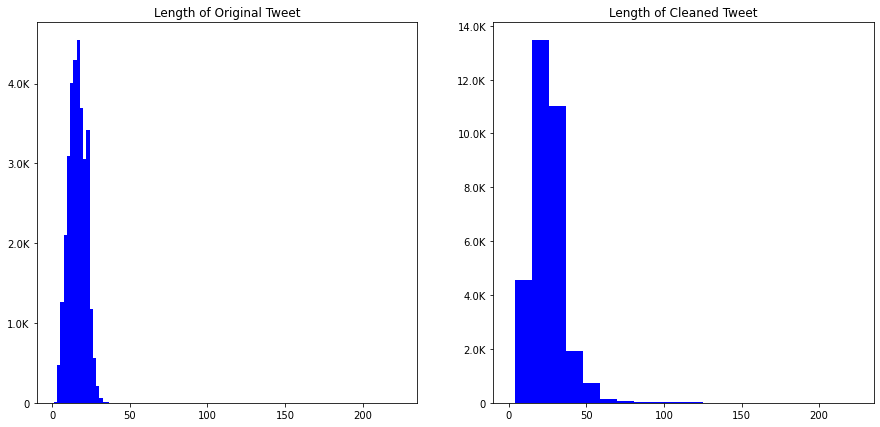

In [ ]:
from pyspark_dist_explore import hist
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15,7), sharex=True)
hist(ax[0], df.select('len_tweet'), bins = 20, color=['blue']);
hist(ax[1], df.select('len_tweet_clean'), bins = 20, color=['blue']);

ax[0].set_title("Length of Original Tweet");
ax[1].set_title("Length of Cleaned Tweet");

#### **Repeat for each class**

Label '1' denotes the tweet is racist/sexist and label '0' denotes the tweet is not racist/sexist.



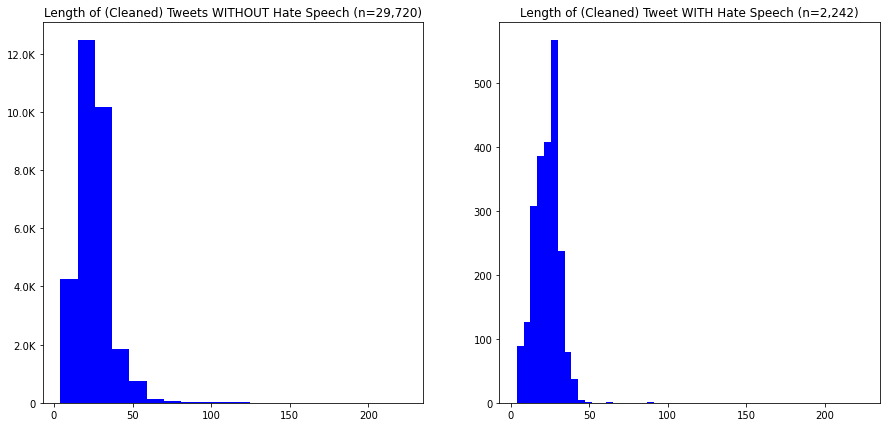

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15,7), sharex=True)

df_0 = df.select(['len_tweet_clean', 'label']).where(df.label == 0)
df_1 = df.select(['len_tweet_clean', 'label']).where(df.label == 1)

hist(ax[0], df_0.select('len_tweet_clean'), bins = 20, color=['blue']);
hist(ax[1], df_1.select('len_tweet_clean'), bins = 20, color=['blue']);

ax[0].set_title(f"Length of (Cleaned) Tweets WITHOUT Hate Speech (n={df_0.count():,.0f})");
ax[1].set_title(f"Length of (Cleaned) Tweet WITH Hate Speech (n={df_1.count():,.0f})");

In [ ]:
printmd("**Regular speech statistics**")

df_0.agg({'len_tweet_clean': 'avg'}).show()
df_0.agg({'len_tweet_clean': 'min'}).show()
df_0.agg({'len_tweet_clean': 'max'}).show()

**Regular speech statistics** 


+--------------------+
|avg(len_tweet_clean)|
+--------------------+
|  24.810060565275908|
+--------------------+

+--------------------+
|min(len_tweet_clean)|
+--------------------+
|                   4|
+--------------------+

+--------------------+
|max(len_tweet_clean)|
+--------------------+
|                 224|
+--------------------+



In [ ]:
printmd("**Hate speech statistics**")

df_1.agg({'len_tweet_clean': 'avg'}).show()
df_1.agg({'len_tweet_clean': 'min'}).show()
df_1.agg({'len_tweet_clean': 'max'}).show()

**Hate speech statistics**

+--------------------+
|avg(len_tweet_clean)|
+--------------------+
|  23.192239072256914|
+--------------------+

+--------------------+
|min(len_tweet_clean)|
+--------------------+
|                   4|
+--------------------+

+--------------------+
|max(len_tweet_clean)|
+--------------------+
|                  91|
+--------------------+



In [ ]:
print("Median tweet length of all data: " + str(df.approxQuantile('len_tweet_clean',[0.5],0.1)[0]))
print("Median tweet length of NOT hate data: " + str(df_0.approxQuantile('len_tweet_clean',[0.5],0.1)[0]))
print("Median tweet length of hate data: " + str(df_1.approxQuantile('len_tweet_clean',[0.5],0.1)[0]))

Median tweet length of all data: 22.0
Median tweet length of NOT hate data: 22.0
Median tweet length of hate data: 21.0
